In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (classification_report, precision_score, recall_score, f1_score, 
                             accuracy_score, confusion_matrix)

# Chapter I - Data Acquisition

In [13]:
articles_info_df = pd.read_csv('input/train_v2.csv', index_col='article_id')
articles_info_df.head()

,title,url,publisher,hostname,timestamp,category
article_id,,,,,,
1,Forex - Pound drops to one-month lows against ...,http://www.nasdaq.com/article/forex-pound-drop...,NASDAQ,www.nasdaq.com,1.390000e+12,4
2,Hertz to Exit Equipment Rental Business in $2....,http://www.foxbusiness.com/industries/2014/03/...,Fox Business,www.foxbusiness.com,1.400000e+12,2
3,Gold ETF inflows return,http://www.resourceinvestor.com/2014/03/09/gol...,Resource Investor,www.resourceinvestor.com,1.390000e+12,4
4,"Hackers call Mt. Gox CEO a liar, say he still ...",http://bgr.com/2014/03/10/mt-gox-fraud-accusat...,BGR,bgr.com,1.390000e+12,4
5,Gold Climbs To Near 6-Month High On Concerns A...,http://www.forbes.com/sites/kitconews/2014/03/...,Forbes,www.forbes.com,1.390000e+12,4


Distribution of different publishers

In [5]:
publisher_counts = articles_info_df.groupby('publisher').size().reset_index(name='count').sort_values(['count'], ascending=False)
publisher_counts.head()

,publisher,count
956,Reuters,167
158,Businessweek,99
778,NASDAQ,95
443,GlobalPost,73
992,San Francisco Chronicle,71


In [6]:
len(articles_info_df['publisher'].unique())

1502

# Chapter II - Exploratory Analysis

### 1. Sentiment feature

In [14]:
sentiment_df = pd.read_csv('../features/sentiment.csv', index_col='article_id')
sentiment_df.head()

,compound,neg,neu,pos
article_id,,,,
1,0.9081,0.078,0.764,0.157
2,0.9860,0.033,0.810,0.157
3,0.9985,0.108,0.749,0.144
4,-0.9524,0.143,0.784,0.073
5,-0.0771,0.113,0.779,0.107


In [21]:
category_df = pd.DataFrame(articles_info_df['category'])
sentiment_category_df = pd.merge(sentiment_df, category_df, left_index=True, right_index=True)
sentiment_category_df.head()

,compound,neg,neu,pos,category
article_id,,,,,
1,0.9081,0.078,0.764,0.157,4
2,0.9860,0.033,0.810,0.157,2
3,0.9985,0.108,0.749,0.144,4
4,-0.9524,0.143,0.784,0.073,4
5,-0.0771,0.113,0.779,0.107,4


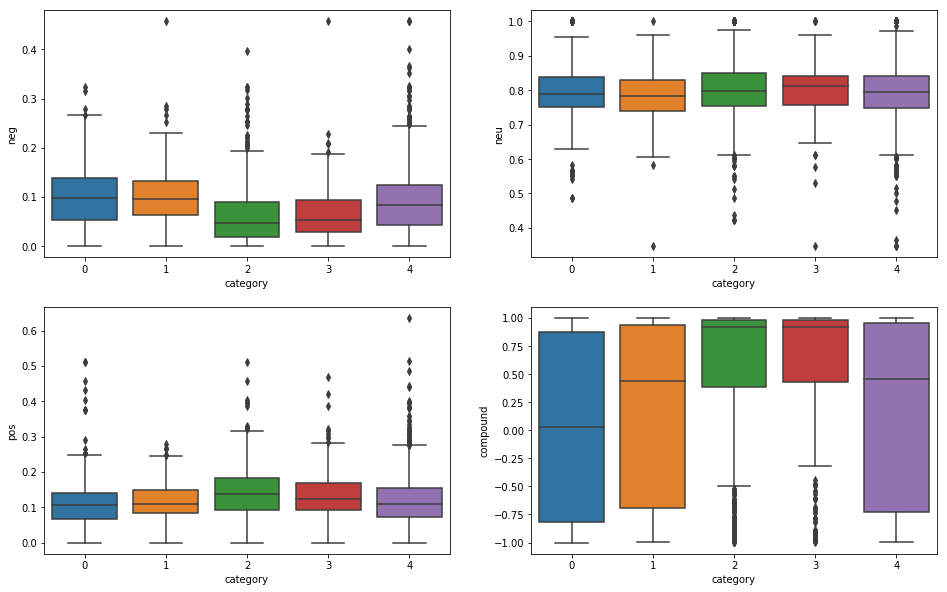

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.boxplot(x="category", y="neg", data=sentiment_category_df, ax=axes[0, 0])
sns.boxplot(x="category", y="neu", data=sentiment_category_df, ax=axes[0, 1])
sns.boxplot(x="category", y="pos", data=sentiment_category_df, ax=axes[1, 0])
sns.boxplot(x="category", y="compound", data=sentiment_category_df, ax=axes[1, 1])

### 2. Part-of-speech features

In [30]:
def std_norm(df, original_col, normalised_col):
    c = df[original_col]
    df[normalised_col] = (c - c.mean())/c.std()

In [34]:
part_of_speech_df = pd.read_csv('../features/part_of_speech.csv', index_col='article_id')
part_of_speech_category_df = pd.merge(part_of_speech_df, category_df, left_index=True, right_index=True)
part_of_speech_category_df['noun_density'] = part_of_speech_category_df['noun_count'] / part_of_speech_category_df['word_count']
part_of_speech_category_df['verb_density'] = part_of_speech_category_df['verb_count'] / part_of_speech_category_df['word_count']
part_of_speech_category_df['adj_density'] = part_of_speech_category_df['adj_count'] / part_of_speech_category_df['word_count']
std_norm(part_of_speech_category_df, 'char_count', 'norm_char_count')
std_norm(part_of_speech_category_df, 'word_count', 'norm_word_count')
std_norm(part_of_speech_category_df, 'paragraph_count', 'norm_paragraph_count')
part_of_speech_category_df = part_of_speech_category_df[['norm_char_count', 'norm_word_count',
                                                         'norm_paragraph_count', 'noun_density', 'verb_density',
                                                         'adj_density', 'category']]
part_of_speech_category_df.head()

,norm_char_count,norm_word_count,norm_paragraph_count,noun_density,verb_density,adj_density,category
article_id,,,,,,,
1,-0.373393,-0.381154,-0.182438,0.430657,0.204380,0.248175,4
10,-0.307558,-0.316840,-0.004006,0.477707,0.248408,0.140127,2
100,0.080624,0.046532,-0.628520,0.496296,0.259259,0.140741,3
1003,-0.308045,-0.329703,-0.360871,0.424837,0.209150,0.222222,2
1004,-0.203685,-0.220370,-0.896170,0.502674,0.197861,0.139037,4


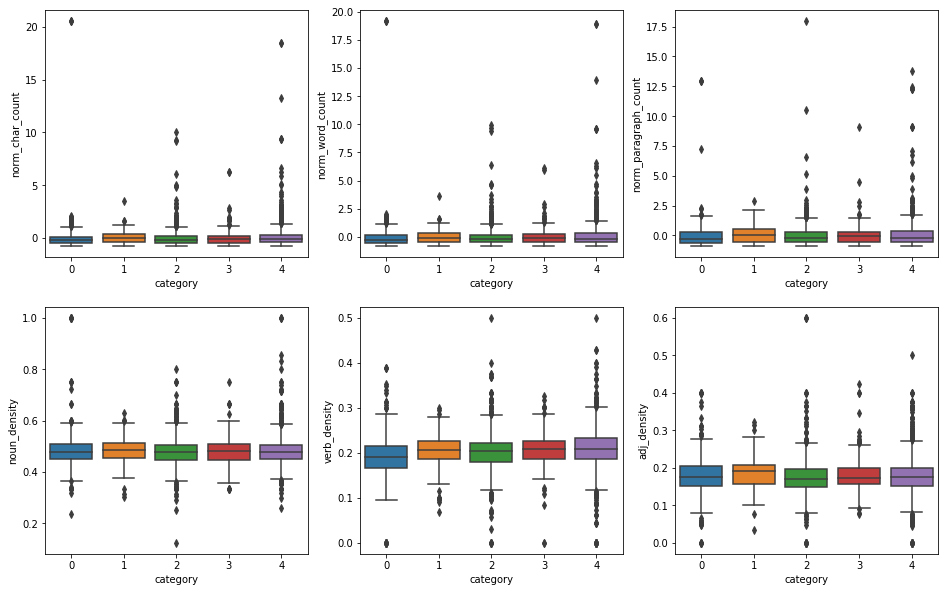

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
sns.boxplot(x="category", y="norm_char_count", data=part_of_speech_category_df, ax=axes[0, 0])
sns.boxplot(x="category", y="norm_word_count", data=part_of_speech_category_df, ax=axes[0, 1])
sns.boxplot(x="category", y="norm_paragraph_count", data=part_of_speech_category_df, ax=axes[0, 2])
sns.boxplot(x="category", y="noun_density", data=part_of_speech_category_df, ax=axes[1, 0])
sns.boxplot(x="category", y="verb_density", data=part_of_speech_category_df, ax=axes[1, 1])
sns.boxplot(x="category", y="adj_density", data=part_of_speech_category_df, ax=axes[1, 2])

### Combine engineered features
Selected sentiment and part-of-speech features are combined. Random forest model is trained for feature selection.

In [38]:
sentiment_compound_df = pd.DataFrame(sentiment_category_df['compound'])
combined_features_df = pd.merge(part_of_speech_category_df, sentiment_compound_df, left_index=True, right_index=True)
combined_features_df.head()

,norm_char_count,norm_word_count,norm_paragraph_count,noun_density,verb_density,adj_density,category,compound
article_id,,,,,,,,
1,-0.373393,-0.381154,-0.182438,0.430657,0.204380,0.248175,4,0.9081
10,-0.307558,-0.316840,-0.004006,0.477707,0.248408,0.140127,2,-0.6808
100,0.080624,0.046532,-0.628520,0.496296,0.259259,0.140741,3,0.9879
1003,-0.308045,-0.329703,-0.360871,0.424837,0.209150,0.222222,2,0.9325
1004,-0.203685,-0.220370,-0.896170,0.502674,0.197861,0.139037,4,0.9821


Export combined features

In [39]:
combined_features_df.to_csv('../features/combined_features.csv')

# Chapter III - Feature Selection

In [50]:
kf = KFold(n_splits=10)
avg_p = 0
avg_r = 0
avg_f1 = 0
avg_accu = 0
features = list(combined_features_df.columns)
features.remove('category')
feature_matrix = combined_features_df[features].values
print(feature_matrix.shape)
y = combined_features_df['category'].values
print(y.shape)

(4566, 7)
(4566,)


In [60]:
print("Start training and predict...")
# full_predicts = np.array([])
for train, test in kf.split(feature_matrix):
#     model = RandomForestClassifier(n_estimators = 200, max_features = 5,
#                                    random_state=0).fit(feature_matrix[train], y[train])
    model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,
                              n_estimators=140).fit(feature_matrix[train], y[train])
    predicts = model.predict(feature_matrix[test])
    print(classification_report(y[test], predicts))
    avg_p += precision_score(y[test], predicts, average='macro')
    avg_r += recall_score(y[test], predicts, average='macro')
    avg_f1 += f1_score(y[test], predicts, average='macro')
    avg_accu += accuracy_score(y[test], predicts)

Start training and predict...
              precision    recall  f1-score   support

           0       0.17      0.09      0.12        43
           1       0.00      0.00      0.00        22
           2       0.42      0.30      0.35       162
           3       0.00      0.00      0.00        24
           4       0.47      0.71      0.57       206

   micro avg       0.44      0.44      0.44       457
   macro avg       0.21      0.22      0.21       457
weighted avg       0.38      0.44      0.39       457



/home/swang/data_env/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/swang/data_env/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/swang/data_env/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/swang/data_env/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', '

              precision    recall  f1-score   support

           0       0.23      0.13      0.17        52
           1       0.00      0.00      0.00        25
           2       0.36      0.41      0.38       127
           3       0.25      0.03      0.06        32
           4       0.53      0.66      0.59       221

   micro avg       0.45      0.45      0.45       457
   macro avg       0.27      0.25      0.24       457
weighted avg       0.40      0.45      0.41       457

              precision    recall  f1-score   support

           0       0.24      0.11      0.15        47
           1       0.00      0.00      0.00        21
           2       0.37      0.38      0.37       130
           3       0.00      0.00      0.00        40
           4       0.51      0.69      0.59       219

   micro avg       0.45      0.45      0.45       457
   macro avg       0.22      0.24      0.22       457
weighted avg       0.37      0.45      0.40       457



/home/swang/data_env/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/swang/data_env/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/swang/data_env/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/swang/data_env/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', '

              precision    recall  f1-score   support

           0       0.22      0.16      0.19        37
           1       0.00      0.00      0.00        24
           2       0.45      0.48      0.47       136
           3       0.00      0.00      0.00        28
           4       0.56      0.69      0.62       232

   micro avg       0.51      0.51      0.51       457
   macro avg       0.25      0.27      0.25       457
weighted avg       0.44      0.51      0.47       457

              precision    recall  f1-score   support

           0       0.20      0.09      0.13        43
           1       0.00      0.00      0.00        26
           2       0.44      0.40      0.42       131
           3       0.00      0.00      0.00        33
           4       0.54      0.75      0.62       224

   micro avg       0.49      0.49      0.49       457
   macro avg       0.23      0.25      0.23       457
weighted avg       0.41      0.49      0.44       457

              precisio

In [61]:
print('Average Precision is %f.' %(avg_p/10.0))
print('Average Recall is %f.' %(avg_r/10.0))
print('Average F1 score is %f.' %(avg_f1/10.0))
print('Average Accuracy is %f.' %(avg_accu/10.0))

Average Precision is 0.980472.
Average Recall is 0.819791.
Average F1 score is 0.848351.
Average Accuracy is 1.147896.


# Chapter IV - Feature Importance Study

In [56]:
for name, importance in zip(features, model.feature_importances_):
    print(name, "=", importance)
importances = model.feature_importances_
indices = np.argsort(importances)
features_in_order = [features[i] for i in indices]

norm_char_count = 0.1273132591144564
norm_word_count = 0.11311047466478313
norm_paragraph_count = 0.0921729630472298
noun_density = 0.1585616933729284
verb_density = 0.16700131036346394
adj_density = 0.15971392558804293
compound = 0.1821263738490954


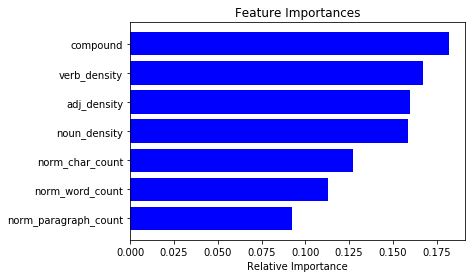

In [57]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features_in_order)
plt.xlabel('Relative Importance')
plt.show()

# References

A Comprehensive Guide to Understand and Implement Text Classification in Python<br/>
https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

# Training error

DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

### part_of_speech_analyzer.py
DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working